## MESA

Mesa is an agent-based modeling (or ABM) framework in Python. It enables users to quickly develop ABMs. It provides a variety of convenience components often used in ABMs, like different kinds of spaces within which agents can interact, different kinds of schedulers for controlling which agents in what order are making their moves, and basic support for dealing with the intrinsic stochastic nature of ABMs. MESA is ideally suited for learning agent-based modeling. It is less suited for developing large-scale computationally heavy ABMs. Given that MESA is a python library, and its focus is on learning ABM, we have chosen to use MESA. The documentation of MESA can be found online: https://mesa.readthedocs.io/en/master/. Besides this tutorial, we recommend you to use it when you are making your assignments for more detailed information.


Any Agent Based Model is typically composed of a collection of **Agents**, which are positioned in a **Space**. The Agents interact with each other typically based on how close they are in the Space. Sometimes they also interact with the Space itself. Agent Based Models are dynamic so they show some kind of pattern over time. To create this dynamic, Agent Based Models use **ticks**. A tick is like a timestep. In each tick, all agents are given the option to act. The order in which Agents can act is very important because Agent Based Models are prone to showing path dependence. Therefore, the order in which agents get to act is typcially handled by a **Scheduler**. 

Let's build a very simple Agent Based Model, using MESA which contains these four components: Agents, Space, Schedulers, and ticks. The model we will build is a simple model of an economy. It consists of a collection of agents which move around randomly in a grid like space. If, after having moved, an agent find itself in a gridcell occopied by  other agents, the agent will give one unit of wealth to a randomly selected other agent in the same grid cell. 

To implement this model, we will extend the Agent and Model class provided by MESA. As space, we will use a MultiGrid. This is a gridd (think excel-like) space where more than one agent can occupy the same cell. As scheduler, we will use the RandomActiviation. This means that at each tick, all agents in a random order get to make their move. 

So we start with importing the classes from MESA that we need.

In [1]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid

Next, we can extend the MESA Model class. For this, we have to implement the `__init__` and the `step` method. The `__init__` is the initial setup of the model (tick=0). So we give our model a space (i.e., `self.space = MultiGrid(width, height, True)`. We also give the model a scheduler (i.e., `self.scheduler = RandomActivation(self)`. Last, we need to populate the grid with agents. We do this by first creating an Agend and next placing it at a randomly selected grid cell (i.e., in the for loop). The step method is short: we just invoke the step method on the scheduler (i.e., `self.scheduler.step()`). 

In [2]:
class MoneyModel(Model):
    """A model with some number of agents.
    
    Parameters
    N : int
        the number of agents in the space
    width : int
            the width of the space
    height : int
             the height of the space
    """
    def __init__(self, N, width, height):
        self.num_agents = N
        
        # the space within which agents move
        self.space = MultiGrid(width, height, True)
        
        # the scheduler
        self.scheduler = RandomActivation(self)

        # initialize the model by creating N agents
        # positioned at a random location in the grid
        for i in range(self.num_agents):
            agent = MoneyAgent(i, self)
            self.scheduler.add(agent)
            
            # Add the agent to a random grid cell
            x = self.random.randrange(self.space.width)
            y = self.random.randrange(self.space.height)
            self.space.place_agent(agent, (x, y))

    def step(self):
        self.scheduler.step()


We also need to extend the Agent class that comes with MESA. In the simplest version, we would again only need to implement the `__init__` and the `step` method. However, in this case, we seperate the `step` method into 2 activities: moving to a randomly selected neighboring cell, and possible giving money. We place both activities in their own methods to clearly seperate these two actions (i.e., we add a `move` and `give_money` method to the Agent class). 

For the move method, we can use the grid of the model to get the neigboring cells, randomly pick one, and then inform the grid to move the agent to this randomly selected grid cell. Perhaps counterintuitively, the Agent does not change its own location. Instead, the grid space moves the Agent through the MESA-method move_agent.

For the `give_money` method, we ask the grid for a list of all agents occuping our current grid cell (with `get_cell_list_contents`). This method is only invoked if the agent has any wealth to give. If not, nothing happens. If there is more than one agent, we randomly select one agent to give wealth to.

Question: look carefully at the give_money method. Do you notice anything odd in how this is currently implemented?

answer: the agent randomly select from the list of agents currently occupying the cell. This list includes also itself, so the agent might give wealth to itself.

In [3]:

class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.space.get_neighborhood(
            self.pos, moore=True, include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.space.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.space.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

This completes the setup of the model. We can now instantiate the model, and run it for a number of ticks

In [7]:
width = 10
height = 10
n_agents = 80
model = MoneyModel(n_agents, width, height)
n_ticks = 10
for _ in range(n_ticks):
    model.step()

As a last step, we can visualize the model results. For example, we can show a histogram of the distribution of wealth over the agents like this

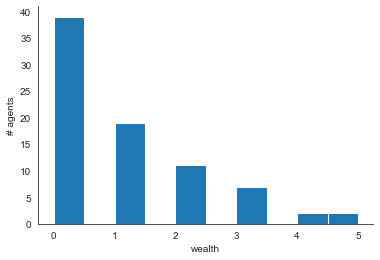

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')

agent_wealth = [a.wealth for a in model.scheduler.agents]

fig, ax = plt.subplots()

ax.hist(agent_wealth)
ax.set_ylabel('# agents')
ax.set_xlabel('wealth')

sns.despine()

plt.show()


We can also take a look at the grid itself like this:

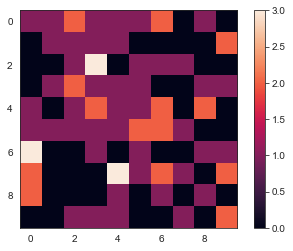

In [9]:
fig, ax = plt.subplots()

agent_counts = np.zeros((model.space.width, model.space.height))
for cell in model.space.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
img = ax.imshow(agent_counts, interpolation='nearest')
fig.colorbar(img, ax=ax)
plt.show()

Question: run the model a few times and replot the results. Do you notice anything strange and can you explain this?

Answer: There is quite some randomness in the model: where the original agents are located, where they move to, and to whom to give wealth. Everytime you rerun the model different random numbers are used and thus you get different results. This is a key and important difference with system dynamics models. ABMs are stochastic, while SD models are deterministic. In future assignments, we will look at this in more detail and also show how we can control the random numbers that are being generated so that the model becomes deterministic. This is desirable for debugging and reproducibility.